# **Homework 3_1**

Выполнил: Касенов Султан

В данной работе попытаемся обучить модели, которые будут предсказывать цену жилья для одного датасета. Для начала импортируем все нужные библиотеки.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model
import sklearn.compose
import sklearn.tree

import seaborn as sns

Скачаем наш датасет и сразу проверим его на наличие NaN values. 

In [2]:
df = pd.read_csv('http://www.soshnikov.com/temp/data/kc_house_data_processed.zip', compression='zip')

Значение false означает, что нам повезло и таких значений нету. 

In [3]:
df.isna().any().any()

False

Теперь можно рассмотреть датасет и начать его чистку.


In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Data Cleaning

Рассмотрим типы признаков. 

In [5]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Удалим id так как он не является признаком.

In [6]:
df = df.drop('id', axis=1)

Следует отметить, что все значения имеют числовой тип однако признак date является обьектом string. Заменим его на числовое значение. 

In [7]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime("%Y%m%d").astype(int)

Проверяем распределение

array([[<AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_above'}>],
       [<AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'zipcode'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'c

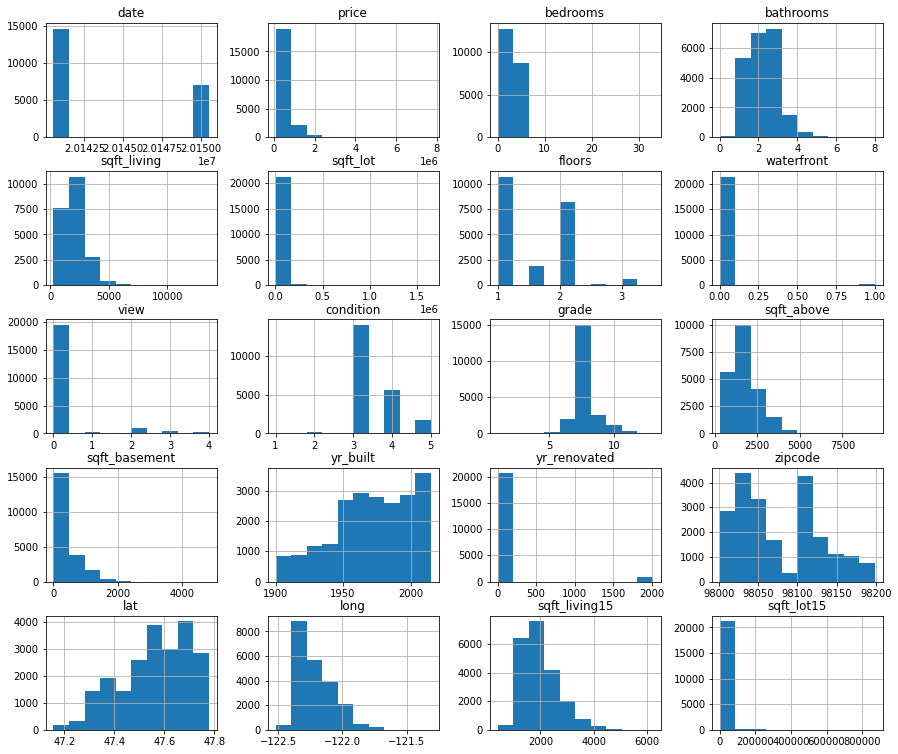

In [8]:
df.hist(figsize=(15,13))

Следует отметить, что цена имеет смещеное распределение и поэтому удобно будет привести его к нормальному используя логарифм. Теперь можно проверить новое распределение.


<AxesSubplot:>

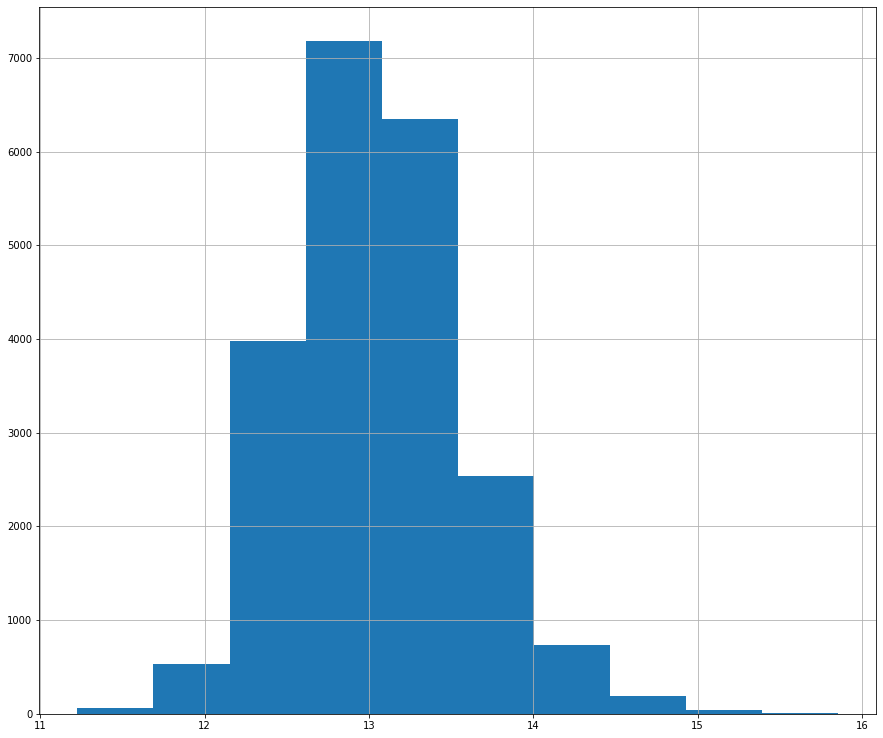

In [9]:
df['log_price'] = np.log(df['price'] + 1)
df['log_price'].hist(figsize=(15,13))

Рассмотрим матрицу корреляции. Некоторые признаки имеют очень низкую корреляцию с ценой, поэтому мы их удалим или попробуем сгенирировать новые признаки. 

<AxesSubplot:>

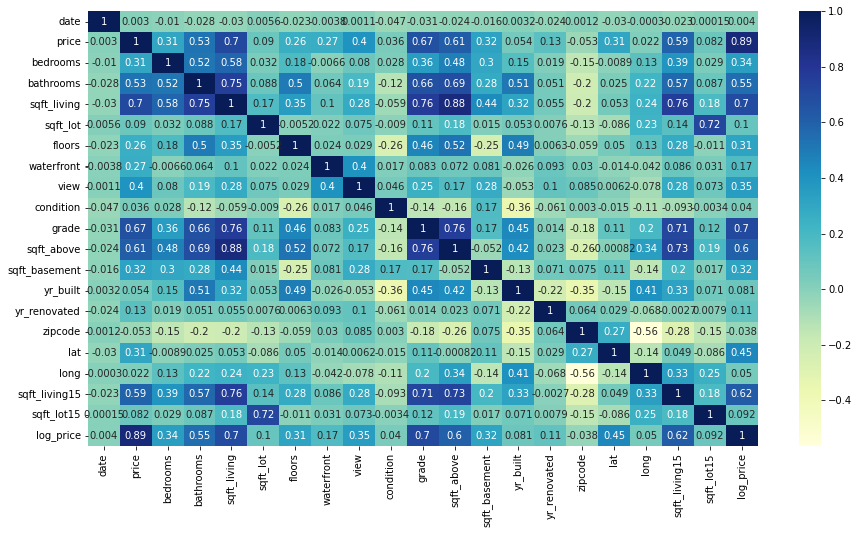

In [10]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')

Делим наш датасет на тестовую и обучающую часть

In [11]:
df_train, df_test = sk.model_selection.train_test_split(df, train_size=0.8, shuffle=True)

**Нормализация значений**

Для начала сохраним названия всех признаков в один список и сразу уберем ненужные признаки. 


In [12]:
features = list(df.columns)
features.remove('price')
features.remove('log_price')
features.remove('date')
features.remove('long')
features.remove('condition')
features.remove('zipcode')
features.remove('yr_renovated')
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'lat',
 'sqft_living15',
 'sqft_lot15']

 Встроим нормализацию в наш конвейер предобработки

In [13]:

transformer = sk.compose.make_column_transformer(
    (sk.preprocessing.StandardScaler(), ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'bathrooms']),
    (sk.preprocessing.MinMaxScaler(), [ 'lat', 'bedrooms']),
    (sk.preprocessing.OneHotEncoder(),['yr_built']),
    remainder='passthrough'
)

X = transformer.fit_transform(df_train[features])

Обучаем модель. 

In [14]:
Y = df_train["log_price"]

model = sk.linear_model.LinearRegression()
model.fit(X, Y)





LinearRegression()

Далее тестируем нашу модель и находим MAE значение в процентах.

In [15]:
X_t = transformer.transform(df_test[features])
Y_t = df_test['log_price']

Y_p = model.predict(X_t)

print(sk.metrics.mean_absolute_percentage_error(Y_p, Y_t))


0.015123775305620913


Можно рассмотреть коэфициенты однако интерпретировать их будет сложно. 

In [16]:
model.coef_, model.intercept_

(array([ 0.06362272,  0.0192019 ,  0.05136265,  0.03643565,  0.06596874,
        -0.00527658,  0.05893748,  0.81087052, -0.07215601,  0.23020591,
         0.21024455,  0.2185833 ,  0.16495341,  0.26648594,  0.2676543 ,
         0.26483385,  0.2625299 ,  0.14563169,  0.24386643,  0.19086951,
         0.22810146,  0.1764193 ,  0.15959335,  0.21425011,  0.14687414,
         0.20133964,  0.20198446,  0.14344074,  0.22926882,  0.20011399,
         0.20403522,  0.16703085,  0.21155074,  0.24637975,  0.21494694,
         0.20779099,  0.18904676,  0.13124202,  0.11584639,  0.09215031,
         0.12346159,  0.10887108, -0.06523897,  0.03584383,  0.07430603,
         0.05260041,  0.09500894,  0.08844093,  0.08852799,  0.0903567 ,
         0.11673384,  0.06474446, -0.02193993, -0.00487621,  0.11521093,
         0.12152702,  0.00627569, -0.02347195,  0.02346917,  0.03139576,
         0.04642457,  0.02953724,  0.02745183, -0.03454004, -0.02990396,
        -0.03361011, -0.03685815, -0.04234075, -0.0

Добавим полиномиальные комбинации признаков чтобы немного улучшить точность. 

In [17]:
poly = sk.preprocessing.PolynomialFeatures()
Xp = poly.fit_transform(X)


Чтобы уменьшить количество кода добавим конвеер чтобы заново не описывать шаги. Также запринтим точность нашей модели, которая равна 75 процентам. 

In [18]:
pipe = sk.pipeline.Pipeline([
    ('ColumnTransform',transformer),
    ('PolyFeatures',poly),
    ('LinearModel',model)
])
pipe.fit(df_train[features], Y)
pipe.score(df_test[features],Y_t)

0.7572374150798438